In [1]:
import os
import h5py
import gc
import glob
import math
import random
import warnings
import librosa
import librosa.display
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.signal import istft
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import tensorflow_addons as tfa

from pathlib import Path
from scipy import stats
from tqdm.notebook import tqdm
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from tensorflow.keras.utils import plot_model
from sklearn.model_selection   import train_test_split

sns.set_theme()
%matplotlib inline 
warnings.filterwarnings('ignore')
display(HTML(''))

In [2]:
DATA_PATH = Path('../input/g2net-detecting-continuous-gravitational-waves')
TRAIN_PATH = DATA_PATH/'train'
TEST_PATH = DATA_PATH/'test'
train_example_with_signal_path = TRAIN_PATH/'cc561e4fc.hdf5'
train_example_without_signal_path = TRAIN_PATH/'fb6db0d08.hdf5'

# Loading metadata

In [3]:
labels_df = pd.read_csv(DATA_PATH/'train_labels.csv')
labels_df.head()

,id,target
0,001121a05,1
1,004f23b2d,1
2,00a6db666,1
3,00f36a6ac,1
4,010a387db,1


In [4]:
def extract_data_from_hdf5(path, labels):
    data = {}
    
    with h5py.File(path, "r") as f:
        ID_key = list(f.keys())[0]
        # Retrieve the frequency data
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])
        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])
        # Retrieve the Hanford decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
        # Get label from training labels if in training set
        data['label'] = labels.loc[labels.id==ID_key].target.item()
        
    return data

In [5]:
def extract_data_from_hdf5_reduced(path, labels):
    data = {}
    
    with h5py.File(path, "r") as f:
        ID_key = list(f.keys())[0]
        # Retrieve the frequency data
        data['id'] = ID_key
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])
        # Retrieve the Livingston decector data
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])
        # Retrieve the Hanford decector data
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
        # Get label from training labels if in training set
        data['label'] = labels.loc[labels.id==ID_key].target.item()
        
    return data

In [6]:
%%time
time_df = pd.DataFrame()
for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
    final_data = dict()
    data = extract_data_from_hdf5(DATA_PATH/'train'/p, labels_df)
    amp1 = data['L1_SFTs_amplitudes']
    amp2 = data['H1_SFTs_amplitudes']
    f = data['freq']
    label = data['label']
    f_m = sum(f)/len(f)
    _, xrec1 = signal.istft(amp1, f_m)
    _, xrec2 = signal.istft(amp2, f_m)
    xrec1_r = signal.resample(xrec1, 16707)
    xrec2_r = signal.resample(xrec2, 16707)
    final_data['L1_resampled_time'] = xrec1_r
    final_data['H1_resampled_time'] = xrec2_r
    final_data['label'] = label
    time_df = time_df.append(final_data, ignore_index=True)

  0%|          | 0/603 [00:00<?, ?it/s]

CPU times: user 3min 57s, sys: 12.2 s, total: 4min 9s
Wall time: 6min 18s


In [7]:
time_df = time_df.sample(frac=1.0)

In [8]:
%%time
train_df = pd.DataFrame()
for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
    data = extract_data_from_hdf5_reduced(DATA_PATH/'train'/p, labels_df)
    train_df = train_df.append(data, ignore_index=True)

  0%|          | 0/603 [00:00<?, ?it/s]

CPU times: user 5.25 s, sys: 1.54 s, total: 6.79 s
Wall time: 16 s


In [9]:
X_l = np.asarray(time_df['L1_resampled_time'].to_list())
X_h = np.asarray(time_df['H1_resampled_time'].to_list())
y = np.asarray(time_df['label'].to_list())

X_l = np.expand_dims(X_l, axis=1)
X_h = np.expand_dims(X_h, axis=1)

In [10]:
def create_lstm(x_input):
        
    lstm = tf.keras.Sequential([
        
        tf.keras.layers.LSTM(128, kernel_initializer='normal',input_shape=(1, X_l.shape[2]), return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(128, kernel_initializer='normal', return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(128, kernel_initializer='normal', return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(units=128, kernel_initializer='normal', activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
        tf.keras.layers.Dropout(0.5)
    ])
    
    features = lstm(x_input)
    x = layers.Dense(256, activation='relu')(features)
    return x

In [11]:
def get_lstm_model():
    # 1) Hanford 
    h_input = tf.keras.layers.Input(shape=(1,X_l.shape[2]), name='x_h')
    # 2) Livingston 
    l_input = tf.keras.layers.Input(shape=(1, X_l.shape[2]), name='x_l')
    
    h_out = create_lstm(h_input)
    l_out = create_lstm(l_input)

    
    # Concatenate embeddings
    x = tf.keras.layers.Concatenate()([h_out, l_out])
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, kernel_initializer='normal')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # Target prediction in range [0,1] with sigmoid activation
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Model
    inputs = [h_input, l_input]
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    
    optimizer = 'adam'

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = [
            tf.keras.metrics.AUC() ,
        ]
    )
    return model

In [12]:
tf.keras.backend.clear_session()
gc.collect()
lstmmodel = get_lstm_model()

2022-12-07 23:46:08.771025: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
lstmhistory = lstmmodel.fit(
        x=[X_l, X_h],
        y=y,
        epochs = 50,
        validation_split=0.2,
        verbose = 1,
    )

2022-12-07 23:46:11.429572: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
16/16 [==============================] - 14s 220ms/step - loss: 1.8346 - auc: 0.4853 - val_loss: 1.5441 - val_auc: 0.5000
Epoch 2/50
16/16 [==============================] - 1s 57ms/step - loss: 1.3936 - auc: 0.4752 - val_loss: 1.1998 - val_auc: 0.5000
Epoch 3/50
16/16 [==============================] - 1s 60ms/step - loss: 1.0980 - auc: 0.5000 - val_loss: 0.9685 - val_auc: 0.5000
Epoch 4/50
16/16 [==============================] - 1s 57ms/step - loss: 0.9079 - auc: 0.4844 - val_loss: 0.8205 - val_auc: 0.5000
Epoch 5/50
16/16 [==============================] - 1s 58ms/step - loss: 0.7887 - auc: 0.5089 - val_loss: 0.7352 - val_auc: 0.5000
Epoch 6/50
16/16 [==============================] - 1s 59ms/step - loss: 0.7283 - auc: 0.5234 - val_loss: 0.6999 - val_auc: 0.5000
Epoch 7/50
16/16 [==============================] - 1s 58ms/step - loss: 0.6948 - auc: 0.4684 - val_loss: 0.6655 - val_auc: 0.5000
Epoch 8/50
16/16 [==============================] - 1s 58ms/step - loss: 0.6678 -

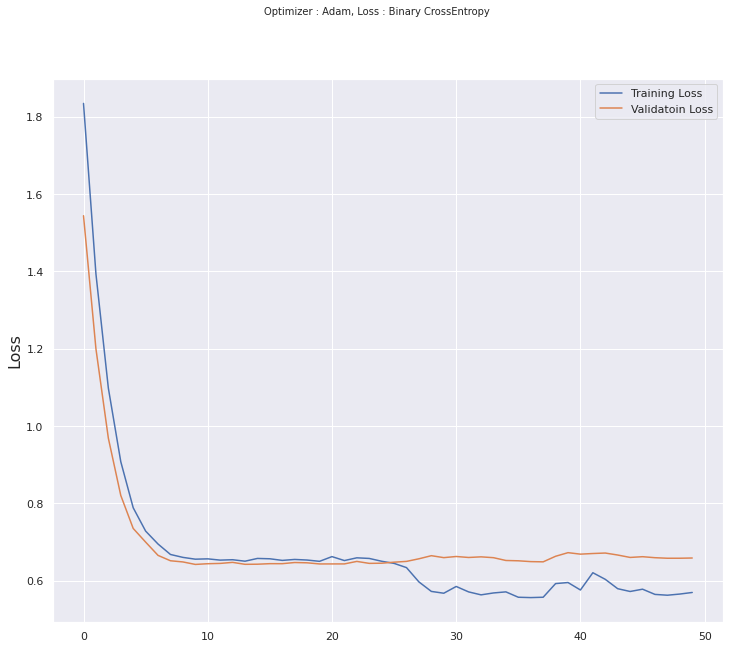

In [14]:
plt.figure(figsize=(12,10))

plt.suptitle('Optimizer : Adam, Loss : Binary CrossEntropy', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(lstmhistory.history['loss'], label='Training Loss')
plt.plot(lstmhistory.history['val_loss'], label='Validatoin Loss')
plt.legend(loc='upper right')

In [15]:
lstmmodel.save_weights('lstmmodel.h5')
del time_df, train_df
gc.collect()

1741